# ML Random Forest Classification – Sentinel-2 + Training Geometries

This example demonstrates an openEO-style ML pipeline:

1. Load Sentinel-2 L2A data cube
2. Load training polygons (GeoJSON) with labels
3. Aggregate temporally (monthly median)
4. Compute NDVI as additional band
5. Extract zonal statistics per training polygon via `aggregate_spatial`
6. Train a Random Forest classifier
7. Apply predictions to the full raster
8. Optionally save as GeoTIFF

In [1]:
from openeo_core import DataCube
from openeo_core.model import mlm_class_random_forest, ml_fit, ml_predict, save_ml_model
import geopandas as gpd

In [2]:
# Load Sentinel-2 L2A data cube (Brittany, France – overlaps with breizh_data)
datacube = DataCube.load_collection(
    "sentinel-2-l2a",
    spatial_extent={"west": -3.8, "south": 48.2, "east": -3.6, "north": 48.4, "crs": 4326},
    temporal_extent=("2022-01-01", "2022-12-31"),
    bands=["blue", "green", "red", "rededge1", "rededge2", "rededge3", "nir"],
    properties={"eo:cloud_cover": {"lt": 50}},
    max_items=50,
)

In [3]:
datacube.data

<xarray.DataArray 'stackstac-dec52585a69a2373908a624f48b24b99' (time: 50,
                                                                bands: 7,
                                                                latitude: 2185,
                                                                longitude: 1446)> Size: 9GB
dask.array<fetch_raster_window, shape=(50, 7, 2185, 1446), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 400B 2022-...
    id                                       (time) <U24 5kB 'S2A_30UVU_20220...
  * bands                                    (bands) <U8 224B 'blue' ... 'nir'
  * longitude                                (longitude) float64 12kB -3.8 .....
  * latitude                                 (latitude) float64 17kB 48.4 ......
    s2:cloud_shadow_percentage               (time) object 400B 15.708733 ......
    ...                                       ...
    view:azimuth                             (time) object 400B None ... None
    proj:centroid                            (time) object 400B None ... None
    view:incidence_angle                     (time) object 400B None ... None
    s2:tile_id                               (time) object 400B None ... None
    gsd                                      (bands) int64 56B 10 10 ... 20 10
    epsg                                     int64 8B 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(np.float64(-3.8000779263841...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-3.80|\n| 0.00,-0.00, 48.40|\n| 0.00, 0.00, ...
    resolution_xy:  (np.float64(0.00013841618439514036), np.float64(9.1540810...

In [4]:
# Load training data (Breizh crop parcels with class_id as label)
training_path = "./input/breizh_data.geojson"
gdf = gpd.read_file(training_path)
# Limit to polygons overlapping the bbox for faster execution
from shapely.geometry import box
bbox = (-3.8, 48.2, -3.6, 48.4)
clip_box = gpd.GeoDataFrame(geometry=[box(*bbox)], crs=4326)
gdf = gpd.clip(gdf, clip_box).head(100)
gdf = gdf.to_crs(4326)

In [5]:
# Aggregate along the temporal dimension (yearly median for simpler features)
datacube = datacube.aggregate_temporal(period="year", reducer="median")

In [6]:
# Calculate NDVI as an additional band
datacube = datacube.ndvi(red="red", nir="nir", target_band="NDVI")

In [7]:
datacube.data

<xarray.DataArray 'stackstac-dec52585a69a2373908a624f48b24b99' (time: 1,
                                                                bands: 8,
                                                                latitude: 2185,
                                                                longitude: 1446)> Size: 202MB
dask.array<concatenate, shape=(1, 8, 2185, 1446), dtype=float64, chunksize=(1, 1, 689, 486), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * bands                                    (bands) object 64B 'blue' ... 'N...
  * longitude                                (longitude) float64 12kB -3.8 .....
  * latitude                                 (latitude) float64 17kB 48.4 ......
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    mgrs:utm_zone                            int64 8B 30
    instruments                              <U3 12B 'msi'
    ...                                       ...
    constellation                            <U10 40B 'sentinel-2'
    proj:epsg                                int64 8B 32630
    mgrs:grid_square                         <U2 8B 'VU'
    gsd                                      (bands) int64 64B 10 10 ... 10 10
    epsg                                     int64 8B 4326
  * time                                     (time) <U4 16B '2022'
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(np.float64(-3.8000779263841...
    crs:            epsg:4326
    transform:      | 0.00, 0.00,-3.80|\n| 0.00,-0.00, 48.40|\n| 0.00, 0.00, ...
    resolution_xy:  (np.float64(0.00013841618439514036), np.float64(9.1540810...

In [8]:
# Aggregate statistics for each training geometry (median per band per month)
# Returns a GeoDataFrame with band values as columns + preserved class_id
training_data = datacube.aggregate_spatial(geometries=gdf, reducer="median")

/Users/brianpondi/.venvs/venv-openeo/lib/python3.10/site-packages/dask/_task_spec.py:767: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


In [9]:
# training_data is a DataCube wrapping a GeoDataFrame; extract for ml_fit
# Use only band-derived columns (exclude GeoJSON metadata). aggregate_spatial may use
# time-suffixed names (e.g. red_2022-12) when temporal dim exists; map to band order.
band_names = list(datacube.data.coords["bands"].values)
available = training_data.data.columns
feature_cols = []
for b in band_names:
    matches = [c for c in available if c == b or str(c).startswith(f"{b}_")]
    if matches:
        feature_cols.append(matches[0])
    else:
        raise KeyError(f"Band {b!r} not found in training columns: {list(available)}")
training_gdf = training_data.data[feature_cols].copy()
training_gdf.columns = band_names  # align with prediction cube
training_gdf["label"] = training_data.data["class_id"].astype(int)
training_gdf = gpd.GeoDataFrame(training_gdf, geometry=training_data.data.geometry, crs=training_data.data.crs)

In [10]:
# Initialize the Random Forest model and train it
rf_model = mlm_class_random_forest(max_variables="sqrt", num_trees=150, seed=42)
rf_model = ml_fit(rf_model, training_set=training_gdf, target="label")

In [11]:
save_ml_model(rf_model, "./output/rf_model_breizh")

False

In [12]:
# Apply the trained model to the data cube (red, nir, NDVI bands)
predictions = ml_predict(datacube.data, rf_model)

In [13]:
# Inspect the prediction cube
predictions

<xarray.DataArray '_predict_block-972adf6df4943f6f7fda96d870711313' (
                                                                     predictions: 1,
                                                                     time: 1,
                                                                     latitude: 2185,
                                                                     longitude: 1446)> Size: 25MB
dask.array<getitem, shape=(1, 1, 2185, 1446), dtype=float64, chunksize=(1, 1, 231, 1446), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * predictions                              (predictions) object 8B '0'
  * time                                     (time) object 8B '2022'
  * latitude                                 (latitude) float64 17kB 48.4 ......
  * longitude                                (longitude) float64 12kB -3.8 .....
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    mgrs:utm_zone                            int64 8B 30
    ...                                       ...
    grid:code                                <U10 40B 'MGRS-30UVU'
    s2:saturated_defective_pixel_percentage  int64 8B 0
    constellation                            <U10 40B 'sentinel-2'
    proj:epsg                                int64 8B 32630
    mgrs:grid_square                         <U2 8B 'VU'
    epsg                                     int64 8B 4326

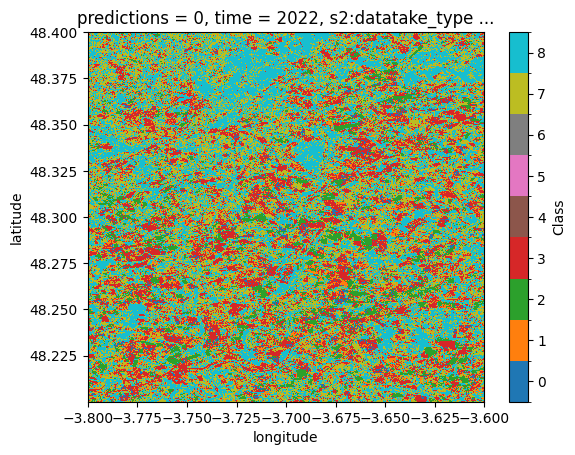

In [14]:
# Visualise predictions with discrete class colours (not continuous)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

pred_da = predictions.sel(predictions="0").squeeze()
vals = np.nan_to_num(pred_da.values, nan=-9999).astype(int)
valid = vals[vals >= 0]
max_class = int(valid.max()) if len(valid) > 0 else 0
n_classes = max_class + 1
cmap = plt.colormaps["tab10"].resampled(n_classes)
bounds = np.arange(-0.5, n_classes + 0.5, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
pred_da.plot(cmap=cmap, norm=norm, cbar_kwargs={"ticks": range(n_classes), "label": "Class"})

In [15]:
# Optional: Save as GeoTIFF
try:
    out_path = "./output/predictions.tif"
    pred_da = predictions.sel(predictions="0").squeeze()
    if "latitude" in pred_da.dims and "longitude" in pred_da.dims:
        pred_da.rio.to_raster(out_path)
        print(f"Saved to {out_path}")
except Exception as e:
    print(f"Save skipped: {e}")

Saved to ./output/predictions.tif
